In [26]:
import sys
sys.path.append('../src')
import preprocessing
import data_augmentation_1D as data_aug
import matplotlib.pyplot as plt 
import numpy as np
from keras.utils import to_categorical
from concurrent.futures import ThreadPoolExecutor, as_completed


In [ ]:
# Définir le chemin racine du dataset
dataset_root = "/mnt/c/Users/onerf/Documents/UMons/Master2/RHEA/src/db/"

# Charger les profils depuis les dossiers spécifiés dans le dataset
profiles  = preprocessing.sleepers_dataset_from_directory(dataset_root + "sleepers_db/")
profiles_test = preprocessing.sleepers_dataset_from_directory(dataset_root + "test/")


In [ ]:
test = profiles.data[900]
augmentations = {
        'original' :test ,
        'vertical flip': np.flip(test).flatten(),
        'horizontal flip':  data_aug.rotate(test, 180), 
        'rotation': data_aug.rotate(test, 0.5, random=True), 
        'shift_y': data_aug.shift_data_y(test), 
        'shift_x': data_aug.shift_data_x(test), 
        'noise': data_aug.add_noise(test), 
        'random': data_aug.random_augmentation(test)
}

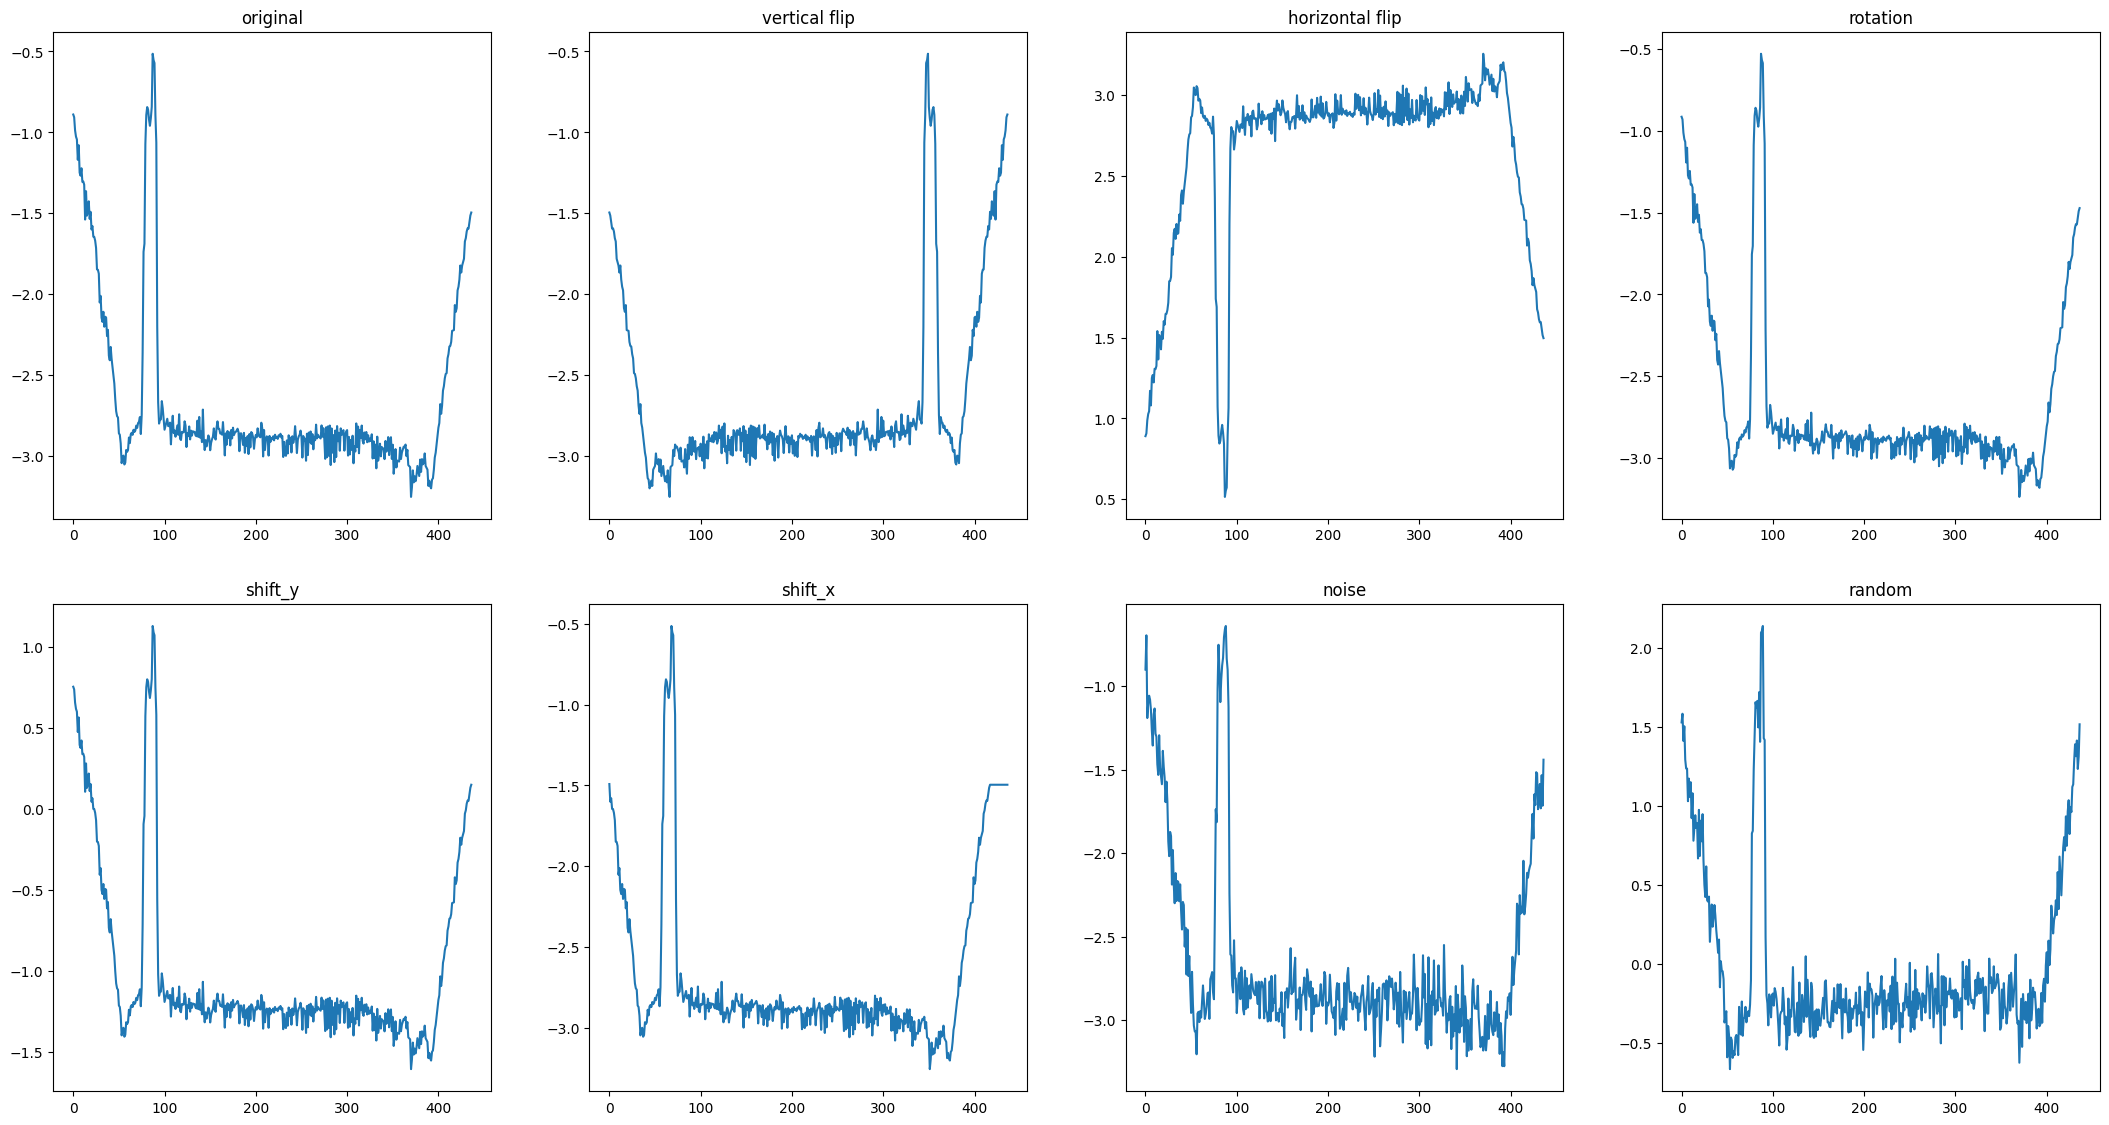

In [ ]:
fig, axs = plt.subplots(2 , 4, figsize=(22,  1.5*len(augmentations) ))
fig.tight_layout(pad=4.0)

line_index = 0  # Indice pour gérer la position actuelle du sous-graphique

# Correction de la récupération de l'objet History depuis la liste
for col_index, augmentation_name in enumerate(augmentations.keys()):
    axs[line_index,col_index%4].plot(augmentations[augmentation_name])
    axs[line_index,col_index%4].set_title(augmentation_name)

    if col_index == 3 : 
        line_index += 1

plt.show()

In [ ]:
# Créer un dictionnaire pour mapper les identifiants uniques des cibles en entiers
id2int = {v: ix for ix, v in enumerate(np.unique(profiles.target))}
int2id = {ix: v for ix, v in enumerate(np.unique(profiles.target))}

# Convertir les cibles en valeurs entières pour faciliter leur manipulation par des algorithmes d'apprentissage automatique
profiles.target = [id2int[val] for val in profiles.target]
profiles.target = to_categorical(profiles.target)

In [ ]:
x, y = profiles.data, profiles.target
# Redimensionnement des données pour ajouter une dimension supplémentaire,
x = x.reshape(x.shape[0], x.shape[1], 1)

In [ ]:
augmented_x = x.copy()
augmented_y = y.copy()

augmentations = [
    ('vertical flip', lambda x: np.flip(x).flatten()), # 4440
    ('horizontal flip', lambda x: data_aug.rotate(x, 180)), # 8880
    ('rotation', lambda x: data_aug.rotate(x, 0.9, random=True)), # 17760
    ('shift_y', lambda x: data_aug.shift_data_y(x)), # 35520
    ('shift_x', lambda x: data_aug.shift_data_x(x)), # 71040
    ('noise', lambda x: data_aug.add_noise(x)), # 142080
    ('random', lambda x: data_aug.random_augmentation(x)) # 284160
]

for name, augmentation in augmentations:
        augmented_data = [augmentation(x_).reshape(-1, 1) for x_ in augmented_x]
        augmented_x = np.concatenate((augmented_x, augmented_data), axis=0)
        augmented_y = np.vstack([augmented_y, augmented_y])

In [ ]:
augmented_x.shape

(284160, 437, 1)

In [ ]:
# Checking label consistency

indexes = [2220,8880,17760,35520,71040,142080]
for index in indexes: 
    assert (augmented_y[0] ==augmented_y[index]).all()
    assert (augmented_y[0] !=augmented_y[index-1]).any()

In [ ]:
categorical_labels = np.argmax(augmented_y, axis=1)
categorical_labels = [int2id[val] for val in categorical_labels]

In [ ]:
import os
import concurrent.futures

base_dir = '/mnt/c/Users/onerf/Documents/UMons/Master2/RHEA/src/db/images/heatmap/'

def save_image(i, x, label):
    dir_path = os.path.join(base_dir, label)
    os.makedirs(dir_path, exist_ok=True)
    file_path = os.path.join(dir_path, f'image_{i}.png')
    preprocessing.profil_to_image(x, file_path, 224)

with ThreadPoolExecutor() as executor:
    # Submit tasks for each image
    futures = [executor.submit(save_image, i, x, label) for i, (x, label) in enumerate(zip(augmented_x, categorical_labels))]

KeyboardInterrupt: 

<Figure size 224x224 with 0 Axes>

NameError: name 'futures' is not defined